In [1]:
pip install numpy pandas torch matplotlib seaborn emoji nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 8.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

Load Data

In [3]:
full_cleaned_df = pd.read_csv('https://github.com/rrandev03/NLP_Final/raw/refs/heads/main/100_data/102_processed/full_cleaned_df.csv')

Importing Transformers

In [26]:
#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel, TFBertForSequenceClassification
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

In [5]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

token_lens = []

for txt in full_cleaned_df['Cleaned_Tweets'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len=np.max(token_lens)
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

MAX TOKENIZED SENTENCE LENGTH: 66


In [6]:
full_cleaned_df = full_cleaned_df.sample(frac=1).reset_index(drop=True)

Tweet Label Column Analysis

In [7]:
full_cleaned_df['Labels'].value_counts()


,count
Labels,
NEUTRAL,154
POSITIVE,92
NEGATIVE,57


In [8]:
full_cleaned_df.head()


,Unnamed: 0,Tweet_Content,Labels,Cleaned_Tweets,Sentiment
0,246,Our government is creating good jobs.\n\nWe’re...,POSITIVE,our government is creating good jobs were attr...,2
1,108,⚡🏎️ Did you know we're giving away electric ve...,POSITIVE,did you know were giving away electric vehicle...,2
2,103,Quotation of the day and those dirty electric ...,NEGATIVE,quotation of the day and those dirty electric ...,0
3,174,BIDEN has a plan to help control gas prices.\n...,NEGATIVE,biden has a plan to help control gas prices 13...,0
4,53,#DYK ➡️ More taxpayer money would be spent on ...,NEGATIVE,dyk more taxpayer money would be spent on elec...,0


Train-Test Split

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(full_cleaned_df['Cleaned_Tweets'], full_cleaned_df['Sentiment'], test_size=0.2, random_state=42)

In [10]:
len(X_train)

242

One Hot Encoding

In [11]:
y_train_spare = y_train.copy()
y_test_spare = y_test.copy()

In [12]:
from sklearn import preprocessing

ohe = preprocessing.OneHotEncoder()
y_train= ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
#y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [13]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

BERT Sentiment Analysis

In [14]:
MAX_LEN=128

def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [15]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
#val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [16]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [27]:
bert_sequence_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
import tensorflow as tf

In [47]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=10000,
    decay_rate=0.9)

bert_sequence_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
#changed learning rate
#added class weights
#used bert sequence classification model instead of adding classification layer

In [29]:
len(X_train)

242

In [30]:
len(X_test)

61

In [31]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(y_train_spare), y=y_train_spare)
class_weights


array([1.71631206, 0.66120219, 1.10502283])

In [48]:
bert_history = bert_sequence_model.fit([train_input_ids, train_attention_masks], y_train, class_weight={i: class_weights[i] for i in range(len(class_weights))}, epochs=20, batch_size=5)

Epoch 1/20
49/49 [==============================] - 53s 166ms/step - loss: 0.5885 - accuracy: 0.7397
Epoch 2/20
49/49 [==============================] - 8s 170ms/step - loss: 0.5694 - accuracy: 0.7066
Epoch 3/20
49/49 [==============================] - 8s 162ms/step - loss: 0.4532 - accuracy: 0.7851
Epoch 4/20
49/49 [==============================] - 8s 158ms/step - loss: 0.3892 - accuracy: 0.8347
Epoch 5/20
49/49 [==============================] - 11s 220ms/step - loss: 0.3099 - accuracy: 0.8719
Epoch 6/20
49/49 [==============================] - 10s 207ms/step - loss: 0.2527 - accuracy: 0.9132
Epoch 7/20
49/49 [==============================] - 9s 187ms/step - loss: 0.1932 - accuracy: 0.9421
Epoch 8/20
49/49 [==============================] - 9s 184ms/step - loss: 0.1442 - accuracy: 0.9587
Epoch 9/20
49/49 [==============================] - 9s 177ms/step - loss: 0.1037 - accuracy: 0.9876
Epoch 10/20
49/49 [==============================] - 7s 147ms/step - loss: 0.0869 - accuracy: 0.9

Test data

In [49]:
logits = bert_sequence_model.predict([test_input_ids, test_attention_masks]).logits
logits

2/2 [==============================] - 4s 241ms/step


array([[-3.9889894e+00, -2.9492443e-02,  3.3247342e+00],
       [-2.8334093e+00,  3.9743524e+00, -2.2111201e+00],
       [-3.1576934e+00,  3.8289416e+00, -1.9242510e+00],
       [-3.1796851e+00,  4.0648055e+00, -1.8848180e+00],
       [ 1.5357567e+00, -6.0893232e-01, -8.3986491e-01],
       [ 4.1715648e-02, -1.7914265e+00,  1.9368658e+00],
       [-3.1467321e+00, -5.2305597e-01,  2.7884738e+00],
       [-3.5885587e+00,  3.9252596e+00, -1.3264213e+00],
       [ 4.2202725e+00, -2.3305795e-01, -2.4473028e+00],
       [-2.5809972e+00, -1.3767148e+00,  3.3503966e+00],
       [ 3.6034529e+00, -9.9952632e-01, -1.5694525e+00],
       [-1.1328704e+00,  9.5053774e-01, -9.8481333e-01],
       [-6.8691927e-01,  3.1349494e+00, -2.7067313e+00],
       [-3.7366700e+00,  3.1697106e+00, -1.6820568e-03],
       [-2.7068968e+00, -1.3847953e+00,  3.9299362e+00],
       [ 2.5217142e+00, -2.1158011e-01, -1.8280016e+00],
       [-3.4182463e+00,  2.6002250e+00,  1.0711860e-03],
       [-1.7911422e+00,  3.9479

In [50]:
probabilities = tf.nn.softmax(logits, axis=-1).numpy()
y_pred = np.zeros_like(probabilities)
y_pred[np.arange(len(y_pred)), probabilities.argmax(1)] = 1

In [51]:
y_pred

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0

              precision    recall  f1-score   support

           0       0.67      0.40      0.50        10
           1       0.68      0.66      0.67        32
           2       0.50      0.63      0.56        19

    accuracy                           0.61        61
   macro avg       0.61      0.56      0.57        61
weighted avg       0.62      0.61      0.61        61



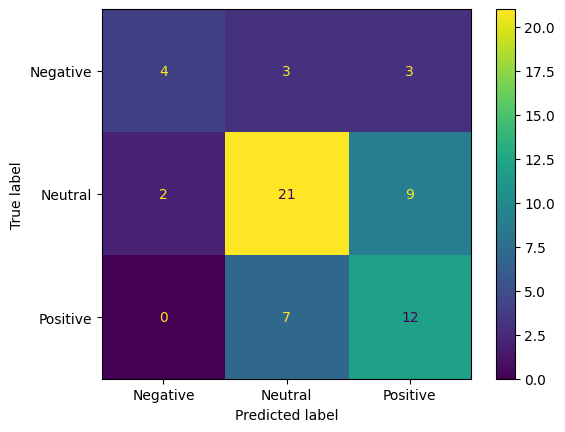

In [52]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

print(classification_report(y_test.argmax(1), y_pred.argmax(1)))
cm  = confusion_matrix(y_test.argmax(1), y_pred.argmax(1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot()
plt.show()
